<a href="https://colab.research.google.com/github/nadairshaid/big-pandas-MIT/blob/decision_tree/Copy_of_Decision_Tree_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing and Mounting**

In [73]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# Setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    precision_recall_curve
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression

# To build classification models 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# For tuning the model
from sklearn.model_selection import GridSearchCV

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [74]:
path = '/Users/andrescervantes/Library/CloudStorage/OneDrive-Personal/03_MIT_IDSS/09_hackathon/Traveldata_train.csv'
travel_train = pd.read_csv(path)

path = '/Users/andrescervantes/Library/CloudStorage/OneDrive-Personal/03_MIT_IDSS/09_hackathon/surveydata_train.csv'
survey_train = pd.read_csv(path)

path = '/Users/andrescervantes/Library/CloudStorage/OneDrive-Personal/03_MIT_IDSS/09_hackathon/Traveldata_test.csv'
travel_test = pd.read_csv(path)

path = '/Users/andrescervantes/Library/CloudStorage/OneDrive-Personal/03_MIT_IDSS/09_hackathon/surveydata_test.csv'
survey_test = pd.read_csv(path)

**Merging Data Frames**

In [75]:
train_df = travel_train.merge(survey_train, how='outer', on= 'ID', indicator= True)
train_df.shape

(94379, 26)

In [76]:
test_df = travel_test.merge(survey_test, how='outer', on= 'ID', indicator= True)
test_df.shape

(35602, 25)

In [77]:
def fill_nas_with_mode(df, col):
    mode = df[col].mode().iloc[0]
    df[col].fillna(mode, inplace=True)

def fill_nas_with_median(df, col):
    median = df[col].median()
    df[col].fillna(median, inplace=True)
    
def cleaning_df(df):
    # filling na
    cat_cols = df.describe(include='object').columns.tolist()
    num_cols = df.describe().columns.tolist()
    
    for col in cat_cols:
        fill_nas_with_mode(df, col)

    for col in num_cols:
        fill_nas_with_median(df, col)
        
    # dummies
    dumm_df = df.drop(columns=['ID','_merge'])
    dumm_df = pd.get_dummies(dumm_df, drop_first=True)

    dumm_df.columns = dumm_df.columns.str.strip()
    dumm_df.columns = dumm_df.columns.str.replace(' ', '_')
    
    return dumm_df

In [78]:
dumm_test_df = cleaning_df(test_df)
dumm_train_df = cleaning_df(train_df)
dumm_test_df

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Gender_Male,Customer_Type_Loyal_Customer,Type_Travel_Personal_Travel,Travel_Class_Eco,Seat_Comfort_Excellent,Seat_Comfort_Extremely_Poor,Seat_Comfort_Good,Seat_Comfort_Needs_Improvement,Seat_Comfort_Poor,Seat_Class_Ordinary,Arrival_Time_Convenient_Excellent,Arrival_Time_Convenient_Extremely_Poor,Arrival_Time_Convenient_Good,Arrival_Time_Convenient_Needs_Improvement,Arrival_Time_Convenient_Poor,Catering_Excellent,Catering_Extremely_Poor,Catering_Good,Catering_Needs_Improvement,Catering_Poor,Platform_Location_Inconvenient,Platform_Location_Manageable,Platform_Location_Needs_Improvement,Platform_Location_Very_Convenient,Onboard_Wifi_Service_Excellent,Onboard_Wifi_Service_Extremely_Poor,Onboard_Wifi_Service_Good,Onboard_Wifi_Service_Needs_Improvement,Onboard_Wifi_Service_Poor,Onboard_Entertainment_Excellent,Onboard_Entertainment_Extremely_Poor,Onboard_Entertainment_Good,Onboard_Entertainment_Needs_Improvement,Onboard_Entertainment_Poor,Online_Support_Excellent,Online_Support_Good,Online_Support_Needs_Improvement,Online_Support_Poor,Ease_of_Online_Booking_Excellent,Ease_of_Online_Booking_Extremely_Poor,Ease_of_Online_Booking_Good,Ease_of_Online_Booking_Needs_Improvement,Ease_of_Online_Booking_Poor,Onboard_Service_Excellent,Onboard_Service_Good,Onboard_Service_Needs_Improvement,Onboard_Service_Poor,Legroom_Excellent,Legroom_Extremely_Poor,Legroom_Good,Legroom_Needs_Improvement,Legroom_Poor,Baggage_Handling_Excellent,Baggage_Handling_Good,Baggage_Handling_Needs_Improvement,Baggage_Handling_Poor,CheckIn_Service_Excellent,CheckIn_Service_Good,CheckIn_Service_Needs_Improvement,CheckIn_Service_Poor,Cleanliness_Excellent,Cleanliness_Good,Cleanliness_Needs_Improvement,Cleanliness_Poor,Online_Boarding_Excellent,Online_Boarding_Extremely_Poor,Online_Boarding_Good,Online_Boarding_Needs_Improvement,Online_Boarding_Poor
0,36.00000,532,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,21.00000,1425,9.00000,28.00000,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,60.00000,2832,0.00000,0.00000,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
3,29.00000,1352,0.00000,0.00000,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
4,18.00000,1610,17.00000,0.00000,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,8.00000,1334,0.00000,0.00000,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
35598,53.00000,1772,0.00000,0.00000,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
35599,22.00000,1180,0.00000,0.00000,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
35600,67.00000,420,23.00000,16.00000,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [79]:
cols_train = set(cleaning_df(train_df).columns.tolist())
cols_test = set(cleaning_df(test_df).columns.tolist())

In [80]:
missing_cols = list(cols_train - cols_test)
missing_cols

['Cleanliness_Extremely_Poor',
 'Onboard_Service_Extremely_Poor',
 'Overall_Experience',
 'Online_Support_Extremely_Poor',
 'Platform_Location_Very_Inconvenient',
 'CheckIn_Service_Extremely_Poor']

In [81]:
for col in missing_cols:
    dumm_test_df[col] = 0

In [82]:
dumm_test_df.shape

(35602, 79)

In [83]:
dumm_test_df[missing_cols]

,Cleanliness_Extremely_Poor,Onboard_Service_Extremely_Poor,Overall_Experience,Online_Support_Extremely_Poor,Platform_Location_Very_Inconvenient,CheckIn_Service_Extremely_Poor
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
35597,0,0,0,0,0,0
35598,0,0,0,0,0,0
35599,0,0,0,0,0,0
35600,0,0,0,0,0,0


# DT model

In [60]:
y = dumm_train_df.Overall_Experience
X = dumm_train_df.drop(columns = ['Overall_Experience'])

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [62]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Attrite', 'Attrite'], yticklabels=['Not Attrite', 'Attrite'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [63]:
dt = DecisionTreeClassifier(class_weight = {0: 0.17, 1: 0.83}, random_state = 1)

In [64]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.17, 1: 0.83}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29950
           1       1.00      1.00      1.00     36115

    accuracy                           1.00     66065
   macro avg       1.00      1.00      1.00     66065
weighted avg       1.00      1.00      1.00     66065



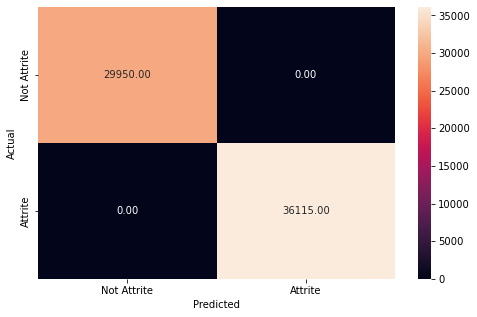

In [66]:
y_train_pred_dt = dt.predict(X_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     12836
           1       0.93      0.92      0.93     15478

    accuracy                           0.92     28314
   macro avg       0.92      0.92      0.92     28314
weighted avg       0.92      0.92      0.92     28314



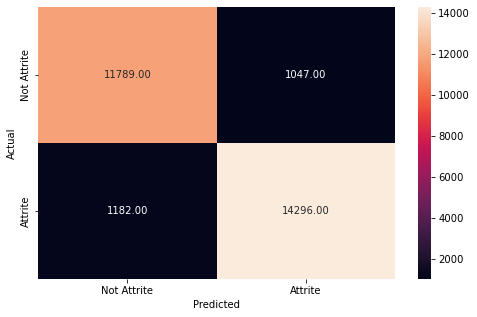

In [67]:
y_test_pred_dt = dt.predict(X_test)

metrics_score(y_test, y_test_pred_dt)

# Making submissions

In [85]:
X = dumm_test_df.drop(columns='Overall_Experience')

In [88]:
preds = dt.predict(X)

In [103]:
submmission_df = pd.DataFrame(data = preds, 
                  index = test_df.ID.values, 
                  columns = ['Overall_Experience'])

In [106]:
submmission_df.rename_axis('ID').to_csv('submission1.csv')